In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
from scripts.Models.ModelBuilder import ModelBuilder
from scripts.Models.CenterDetector.config import CFG as CCFG
from scripts.Models.PartsDetector.config import CFG as PCFG
import albumentations as A

In [2]:
class Controller:
    def __init__(self, center_model_path, parts_model_path, center_transforms, parts_transforms):
        self.center_model_path = center_model_path
        self.parts_model_path = parts_model_path
        self.center_transforms = center_transforms
        self.parts_transforms = parts_transforms
        self.center_detector_model, self.parts_detector_model = self.build_models()

    def build_models(self):
        model_builder = ModelBuilder(CCFG, use_my_model=True, pretrained_model_path=self.center_model_path)
        center_detector_model = model_builder.get_model()

        model_builder = ModelBuilder(PCFG, use_my_model=True, pretrained_model_path=self.parts_model_path)
        parts_detector_model = model_builder.get_model()

        return center_detector_model, parts_detector_model

    def prepare_img_for_center_detector(self, img):
        img = self.center_transforms(image=img)["image"]
        img = torch.tensor(img)
        img = img.permute(-1, 0, 1)
        img = torch.unsqueeze(img[0], 0)
        img = img.to(CCFG.device, dtype=torch.float)
        img = torch.unsqueeze(img, 0)
        return img

    def prepare_img_for_parts_detector(self, img):
        img = self.parts_transforms(image=img)["image"]
        img = torch.tensor(img)
        img = img.permute(-1, 0, 1)
        img = torch.unsqueeze(img, 0)
        img = img.to(CCFG.device, dtype=torch.float)
        return img

    @staticmethod
    def get_cropped_image(img, backbone_coordinates):
        x_center_original, y_center_original = backbone_coordinates
        left_to_center, right_to_center = CCFG.img_size[0] // 2, CCFG.img_size[1] // 2

        crop_from_y = y_center_original - left_to_center if y_center_original > left_to_center else 0
        crop_from_x = x_center_original - right_to_center if x_center_original > right_to_center else 0
        crop_to_y = y_center_original + right_to_center
        crop_to_x = x_center_original + left_to_center
        cropped_image = img[crop_from_y: crop_to_y, crop_from_x: crop_to_x]

        return cropped_image, crop_from_y, crop_from_x

    @staticmethod
    def _rescale_coord_for_orig_img(img, coords):
        y_scale = img.shape[0] / CCFG.img_size[0]
        x_scale = img.shape[1] / CCFG.img_size[1]
        coords = [(int(coord[1]*x_scale), int(coord[0]*y_scale)) for coord in coords]
        return coords

    @staticmethod
    def _get_xy_of_preds(pred):
        pred = torch.squeeze(pred, 0)
        coords = [(pred[i]==torch.max(pred[i])).nonzero()[0] for i in range(pred.shape[0])]
        return coords

    def _predict_img(self, img, is_part_detector):
        with torch.no_grad():
            pred = self.parts_detector_model(img) if is_part_detector else self.center_detector_model(img)
            pred = (torch.nn.Sigmoid()(pred) > 0.5).double()

        return pred.cpu().detach()

    def get_predicted_image(self, orig_img):
        # center detector
        img = self.prepare_img_for_center_detector(orig_img)
        center_pred = self._predict_img(img, is_part_detector=False)
        coords = Controller._get_xy_of_preds(center_pred)
        coords = Controller._rescale_coord_for_orig_img(orig_img, coords)
        center_cropped_image, crop_from_y, crop_from_x = Controller.get_cropped_image(orig_img, coords[0])

        # parts detector
        center_cropped_image = self.prepare_img_for_parts_detector(center_cropped_image)
        parts_pred = self._predict_img(center_cropped_image, is_part_detector=True)
        coords = Controller._get_xy_of_preds(parts_pred)
        for c in coords:
            orig_img = cv2.circle(orig_img, (int(c[1]+crop_from_x), int(c[0]+crop_from_y)), 10, (0,0,255), -1)

        return orig_img

In [3]:
center_transforms = A.Compose([
    A.Resize(*CCFG.img_size, interpolation=cv2.INTER_NEAREST),
    A.Normalize()
], p=1.0)

parts_transforms =  A.Compose([
    A.Normalize(),
    A.PadIfNeeded(PCFG.img_size[0], PCFG.img_size[1],
                  position = A.transforms.PadIfNeeded.PositionType.BOTTOM_RIGHT,
                  border_mode = cv2.BORDER_CONSTANT,
                  value=0, mask_value=0),
], p=1.0)

In [4]:
controller = Controller("CenterDetector/weights.bin", "PartsDetector/weights.bin", center_transforms, parts_transforms)

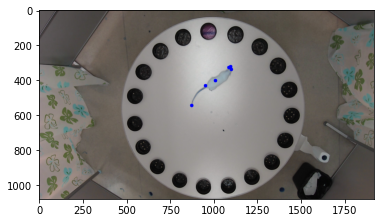

In [6]:
img = cv2.imread("/home/raphael/Desktop/Repos/mouse_behaviour_tracker/scripts/Models/CenterDetector/images/WIN_20201123_1-1/80.jpg")

pred_img = controller.get_predicted_image(img)
plt.imshow(pred_img)